# 01NAEX – HW2: Reaction Time Experiment Analysis

**Project Goal:** Analyze influential variables on human reaction time measured with a keyboard.

## 1. Experimental Factors

The experiment investigates seven two-level factors coded as -1 (low) and +1 (high), with one of those varibales being numerical ("Cue delay").

| Code | Factor Description | Level (-1) | Level (+1) | Hypothesis |
|---|---|---|---|---|
| **F_A** | Stimulus Type | Digits | Letters | Digits might be processed faster mentally. |
| **F_B** | Text Motion | Static | Moving | Motion adds cognitive load (slower). |
| **F_C** | Background Color | Random | White | Random backgrounds create visual noise. |
| **F_D** | Font Size | Large | Small | Small text requires more focus. |
| **F_E** | Text Color | Random | Black | Low contrast reduces readability. |
| **F_F** | Cue Delay | Short (2s) | Long (5s) | Longer delays might increase anticipation or loss of focus. |
| **F_G** | Frame Motion | Shaking | Static | Peripheral motion distracts the user. |

**Response Variable:** Median Reaction Time (ms).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools

# Aesthetic configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Loading and Preprocessing

**Statistical Step:** Aggregation.
We aggregate the raw trials into a single value per run. Using the **median** is a robust statistical estimator for reaction time tasks, filtering out "slow" outliers caused by distraction.


We deleted every 1st measurement because it took extra time to click on the response bar.

In [ ]:
# 1. Load Data
col_names = [
    "Timestamp", "User", "StimulusType", "FontSize", "TextMotion",
    "TextContent", "FrameMotion", "FrameMotionBool", "TextColor",
    "BackgroundColor", "MinDelay", "MaxDelay", "TotalTrials",
    "TrialNum", "StimulusValue", "ReactionTime"
]
raw = pd.read_csv("/content/drive/MyDrive/data_NAEX_group_project.csv", header=None, names=col_names)

# 2. Encode Factors
df = raw.copy()

# Identify and delete every tenth measurement
indices_to_delete = df.index[::10]
deleted_measurements = df.loc[indices_to_delete, 'ReactionTime']
print("Measurements deleted (every tenth, starting from 0):\n", deleted_measurements)
df = df.drop(indices_to_delete)



# Mappings (See Table in Section 1)
df["F_A"] = df["StimulusType"].apply(lambda x: 1 if "Letters" in str(x) else -1)
df["F_B"] = df["TextMotion"].apply(lambda x: 1 if "Static" in str(x) else -1)
df["F_C"] = df["BackgroundColor"].apply(lambda x: 1 if "White" in str(x) else -1)
df["F_D"] = df["FontSize"].apply(lambda x: 1 if "Small" in str(x) else -1)
df["F_E"] = df["TextColor"].apply(lambda x: 1 if "Black" in str(x) else -1)
df["F_F"] = df["MaxDelay"].apply(lambda x: 1 if x > 3 else -1)
df["F_G"] = df["FrameMotion"].apply(lambda x: 1 if "Static" in str(x) else -1)

df.rename(columns={"User": "student", "ReactionTime": "reaction_time_ms"}, inplace=True)

# 3. Aggregate (Median)
factor_cols = ["F_A", "F_B", "F_C", "F_D", "F_E", "F_F", "F_G"]
summary = (
    df
    .groupby(["student"] + factor_cols, as_index=False)
    ["reaction_time_ms"].median()
)

print(f"Dataset aggregated into {len(summary)} unique runs.")
display(summary.head())


Measurements deleted (every tenth, starting from 0):
 0       4404.45
10      2843.82
20      2354.01
30      3256.01
40      2588.62
         ...   
1230    2437.58
1240    3770.85
1250    2823.74
1260    5241.78
1270    3186.81
Name: ReactionTime, Length: 128, dtype: float64
Dataset aggregated into 127 unique runs.


,student,F_A,F_B,F_C,F_D,F_E,F_F,F_G,reaction_time_ms
0,Aymeric,-1,1,-1,-1,-1,-1,-1,2549.37
1,Aymeric,-1,1,-1,-1,-1,-1,1,979.63
2,Aymeric,-1,1,-1,-1,-1,1,-1,1246.31
3,Aymeric,-1,1,-1,-1,-1,1,1,1150.35
4,Aymeric,-1,1,-1,-1,1,-1,-1,1364.33


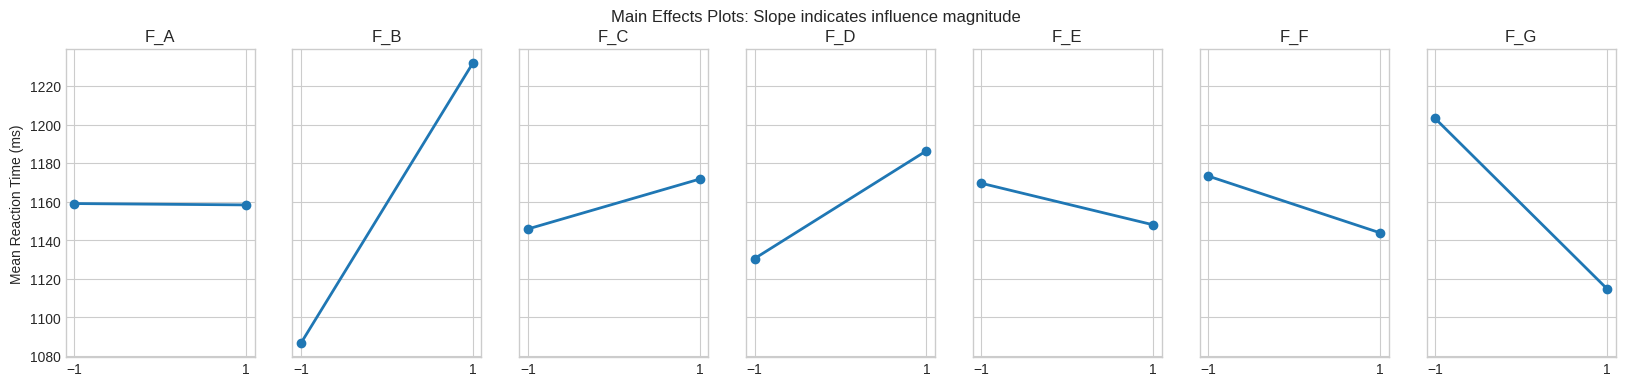

In [ ]:
# Visualizing Main Effects Direction
fig, axes = plt.subplots(1, 7, figsize=(20, 4), sharey=True)
for i, factor in enumerate(factor_cols):
    df_plot = summary.groupby(factor)["reaction_time_ms"].mean().reset_index()
    axes[i].plot(df_plot[factor], df_plot["reaction_time_ms"], marker="o", linewidth=2)
    axes[i].set_title(factor)
    axes[i].set_xticks([-1, 1])
    if i == 0: axes[i].set_ylabel("Mean Reaction Time (ms)")
plt.suptitle("Main Effects Plots: Slope indicates influence magnitude")
plt.show()

## 3. Statistical Modeling (ANOVA)

### Modeling Strategy
We fit a linear regression model to quantify the significance of the effects identified above.

**The importance of Blocking:**
We treat `student` as a block factor. This partitions the total variability:
$$ SS_{Total} = SS_{Factors} + SS_{Blocks} + SS_{Error} $$
By isolating $SS_{Blocks}$ (the natural speed difference between students), we effectively shrink $SS_{Error}$, making the F-tests for our factors ($F_A, F_B...$) more sensitive.

We start with a "Full Model" containing all main effects and all 4-way interactions and then analyze the ANOVA table.

In [ ]:
# Prepare data: Convert student to categorical to treat as Block
model_df = summary.copy()
model_df["student"] = model_df["student"].astype("category")

# Fit Full Model
# F_A + F_B... ensures no conflict with Python keywords
formula = "reaction_time_ms ~ student + (F_A + F_B + F_C + F_D + F_E + F_F + F_G)**4"
lm = smf.ols(formula, data=model_df).fit()

# ANOVA Table (Type II Sum of Squares)
anova_table = sm.stats.anova_lm(lm, typ=2)
print("Top 10 Most Significant Factors (by F-value):")
display(anova_table.sort_values(by="F", ascending=False))

Top 10 Most Significant Factors (by F-value):


,sum_sq,df,F,PR(>F)
student,1.203664e+08,3.0,3141.961996,1.729611e-35
F_B,1.985589e+06,1.0,155.491273,5.990513e-13
F_A:F_B,1.789494e+06,1.0,140.135139,2.052033e-12
F_A,4.437613e+05,1.0,34.750909,2.428461e-06
F_G,2.399199e+05,1.0,18.788106,1.703794e-04
...,...,...,...,...
F_C:F_F,1.112452e+02,1.0,0.008712,9.263013e-01
F_C:F_E:F_G,1.061487e+02,1.0,0.008312,9.280044e-01
F_D:F_G,6.774123e+00,1.0,0.000530,9.817880e-01
F_D:F_E:F_F,4.682843e+00,1.0,0.000367,9.848575e-01


## 4. Exploratory Analysis & Effect Screening

The system is usually dominated by main effects and low-order interactions.

To validate this, we compute the magnitude of effects and visualize them using a **Daniel Plot (Half-Normal Plot)**.
- **Signal:** Factors that deviate from the straight line.
- **Noise:** Factors that align with the straight line (normal distribution of error).

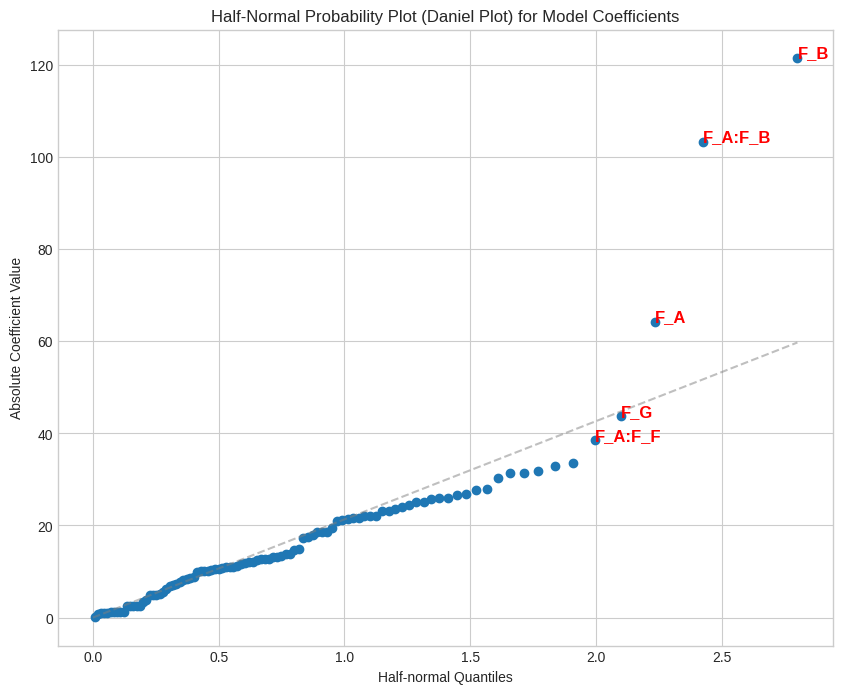

In [ ]:
# --- Daniel Plot for lm model coefficients ---

# Extract coefficients from the fitted model, excluding intercept and student terms
model_coeffs = lm.params.drop(labels=['Intercept'], errors='ignore')
model_coeffs = model_coeffs[~model_coeffs.index.str.startswith('student')]

eff_values_lm = np.array(model_coeffs.values)
eff_abs_lm = np.abs(eff_values_lm)
eff_sorted_idx_lm = np.argsort(eff_abs_lm)
eff_sorted_lm = eff_abs_lm[eff_sorted_idx_lm]
labels_sorted_lm = [model_coeffs.index[i] for i in eff_sorted_idx_lm]

probs_lm = (np.arange(1, len(eff_sorted_lm) + 1) - 0.5) / len(eff_sorted_lm)
theoretical_lm = stats.norm.ppf((probs_lm + 1) / 2)

plt.figure(figsize=(10, 8))
plt.scatter(theoretical_lm, eff_sorted_lm)
plt.plot([0, max(theoretical_lm)], [0, max(theoretical_lm)*np.mean(eff_sorted_lm)/np.mean(theoretical_lm)],
         color='grey', linestyle='--', alpha=0.5)

# Label the top 5 most significant effects
num_labels = min(5, len(labels_sorted_lm))
for x, y, lab in zip(theoretical_lm[-num_labels:], eff_sorted_lm[-num_labels:], labels_sorted_lm[-num_labels:]):
    plt.text(x, y, lab, fontsize=12, color='red', fontweight='bold')

plt.xlabel("Half-normal Quantiles")
plt.ylabel("Absolute Coefficient Value")
plt.title("Half-Normal Probability Plot (Daniel Plot) for Model Coefficients")
plt.grid(True)
plt.show()

## 5. Model Refinement & Diagnostics

Statistically significant main factors:
 - F_A: stimulus type (digits vs. letters)
 - F_B: text motion
 - F_G: frame motion
interactions:
 - F_A:F_B: this is more interesting because we would expect F_B:F_G to be significant but additional movement apparantely does not significantly increase reaction time

These variables being significant is very logical. Although the Half-Normal plot highlights F_A:F_F as significant, the ANOVA p-value of this interaction is 0.15, so that is why we have not selected it to our reduced model.

                            OLS Regression Results                            
Dep. Variable:       reaction_time_ms   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     9.950
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           5.30e-07
Time:                        12:08:36   Log-Likelihood:                -835.06
No. Observations:                 127   AIC:                             1680.
Df Residuals:                     122   BIC:                             1694.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

,sum_sq,df,F,PR(>F)
student,1.203664e+08,3.0,1279.963979,5.457381e-92
F_A,4.720333e+05,1.0,15.058654,1.695329e-04
F_B,2.098685e+06,1.0,66.951591,3.073012e-13
F_G,2.586312e+05,1.0,8.250768,4.805363e-03
F_A:F_B,1.902169e+06,1.0,60.682380,2.482331e-12
Residual,3.824250e+06,122.0,NaN,NaN


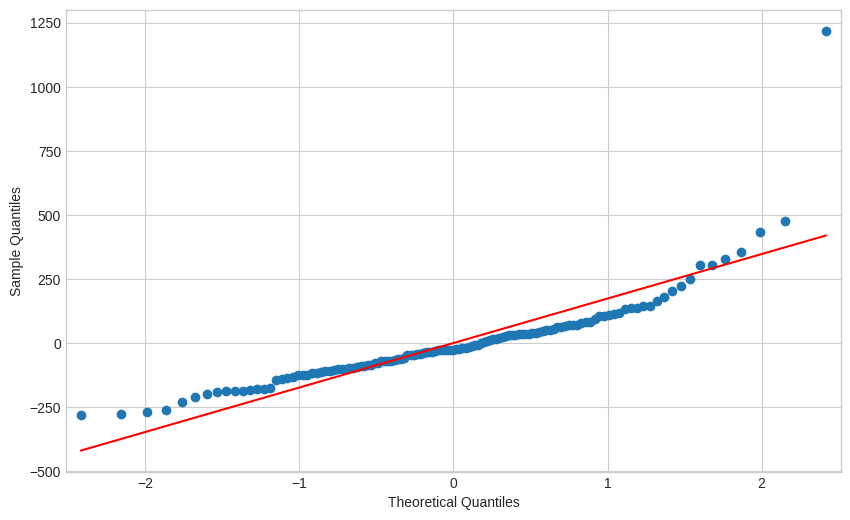

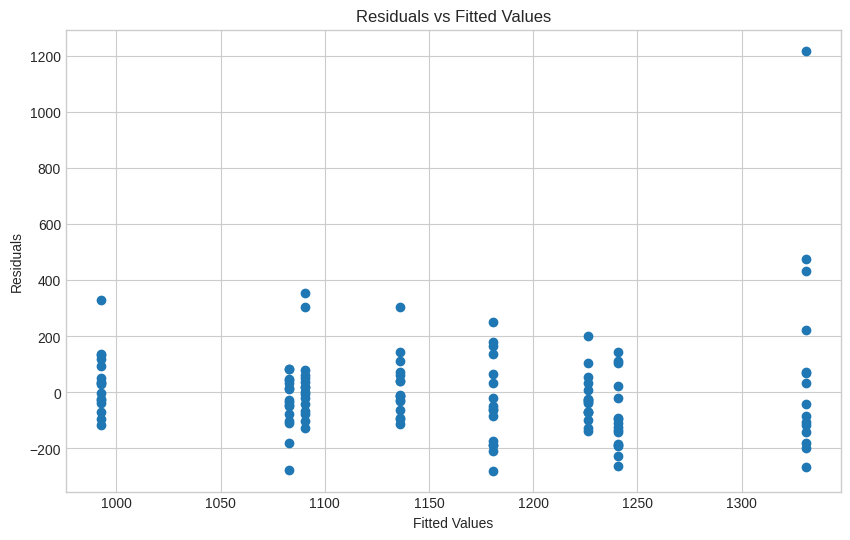

In [ ]:
reduced_model = smf.ols("reaction_time_ms ~ student + (F_A + F_B + F_G + F_A*F_B)", data=model_df).fit()
print(reduced_model.summary())
anova_reduced = sm.stats.anova_lm(reduced_model, typ=2)
display(anova_reduced)
qq_plot_reduced_model = sm.qqplot(reduced_model.resid, line='s')
plt.show()
plt.scatter(reduced_model.fittedvalues, reduced_model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

## 6. Optimization: Finding the Best Settings

### Interaction Analysis
Main effects can be misleading if interactions are strong. For example, if **Frame Motion** hurts performance ONLY when **Font Size** is small, we cannot simply say "Small fonts are bad". We must look at the combination.

The Heatmap below shows the predicted reaction time for the cross-section of the two most important factors found by our model.

## Plot F_A:F_F Interaction

### Subtask:
We shall inspect the interaction between F_A:F_F as suggested by the Half-prob. plot


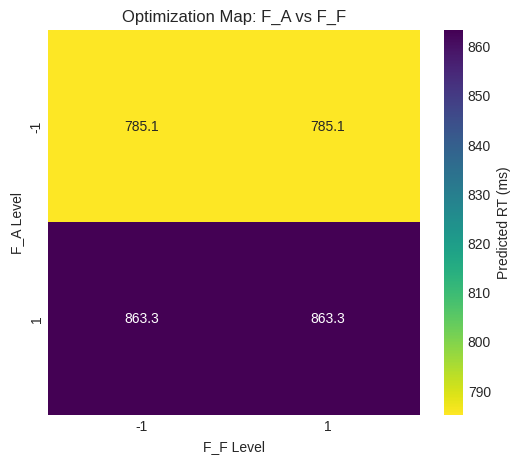

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# 1. Define the two factors for interaction plotting
f1_aa = 'F_A'
f2_ff = 'F_F'

# 2. Create a prediction grid for these two factors
grid_data_af = list(itertools.product([-1, 1], [-1, 1]))
grid_af = pd.DataFrame(grid_data_af, columns=[f1_aa, f2_ff])

# 3. For all other factors in factor_cols (excluding f1_aa and f2_ff), set their values to optimal levels
# Ensure opt_row_df is correctly created if it doesn't exist or is not up-to-date
if 'opt_row_df' not in locals() or opt_row_df.empty:
    opt_row_df = pd.DataFrame([opt_row.drop('student').to_dict()])

for f in factor_cols:
    if f not in [f1_aa, f2_ff]:
        grid_af[f] = opt_row_df[f].iloc[0] # Use optimal level for factors not being plotted

# 4. Set the 'student' column in the grid to the first category of the 'student' column from model_df
grid_af["student"] = model_df["student"].cat.categories[0]

# 5. Predict the reaction times for this grid using the reduced_model
grid_af["pred"] = reduced_model.predict(grid_af)

# 6. Pivot the prediction grid to prepare it for a heatmap
grid_pivot_af = grid_af.pivot(index=f1_aa, columns=f2_ff, values="pred")

# 7. Generate a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(grid_pivot_af, annot=True, fmt=".1f", cmap="viridis_r", cbar_kws={'label': 'Predicted RT (ms)'})

# 8. Add a title to the heatmap
plt.title(f"Optimization Map: {f1_aa} vs {f2_ff}")

# 9. Label the x and y axes
plt.ylabel(f"{f1_aa} Level")
plt.xlabel(f"{f2_ff} Level")

# 10. Display the plot
plt.show()

It shows no interaction due to the strong main effect of F_A

## Plot F_A:F_B interaction

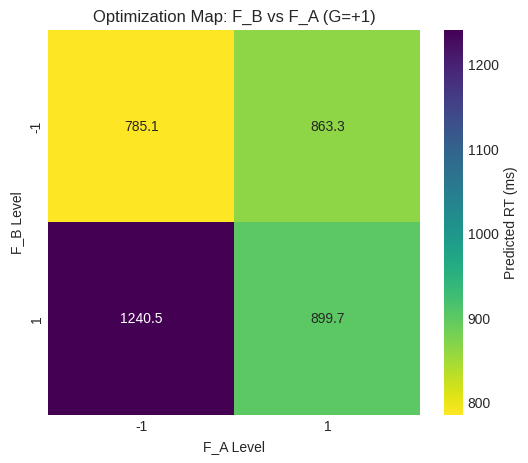

In [ ]:
# Identify top 2 factors for plotting
sorted_factors = anova_table.drop("Residual", errors='ignore').sort_values(by="F", ascending=False)
top_factors = [idx for idx in sorted_factors.index if ":" not in idx and "student" not in idx][:2]

if len(top_factors) >= 2:
    f1, f2 = top_factors[0], top_factors[1]

    # Create prediction grid for the two plotting factors
    grid_data = list(itertools.product([-1, 1], [-1, 1]))
    grid = pd.DataFrame(grid_data, columns=[f1, f2])

    # Set other factors to their optimal levels from opt_row for a more representative optimization map
    for f in factor_cols:
        if f not in [f1, f2]:
            grid[f] = opt_row[f] # Use optimal level for factors not being plotted
    # Ensure the student is set to the reference category, consistent with opt_row
    grid["student"] = model_df["student"].cat.categories[0]

    # Predict
    grid["pred"] = reduced_model.predict(grid)
    grid_pivot = grid.pivot(index=f1, columns=f2, values="pred")

    # Plot Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(grid_pivot, annot=True, fmt=".1f", cmap="viridis_r", cbar_kws={'label': 'Predicted RT (ms)'})
    plt.title(f"Optimization Map: {f1} vs {f2} (G=+1)")
    plt.ylabel(f"{f1} Level")
    plt.xlabel(f"{f2} Level")
    plt.show()
else:
    print("Not enough significant factors for 2D visualization.")

This plot on the other hand shows the significance of the interaction, again showing the strength of main effect of F_A, which makes a lot of sense, since there are only 10 digits and 26 letters on a keyboard.

F_B - text motion at setting +1 (moving) is also very influential, given that this interaction is significant.

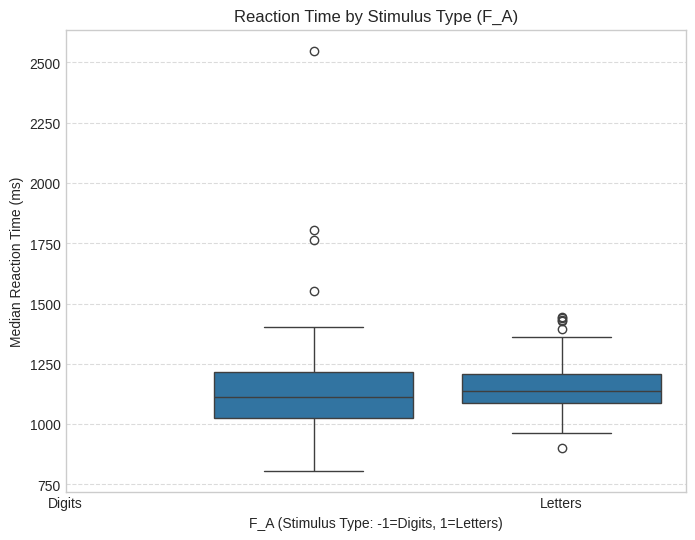

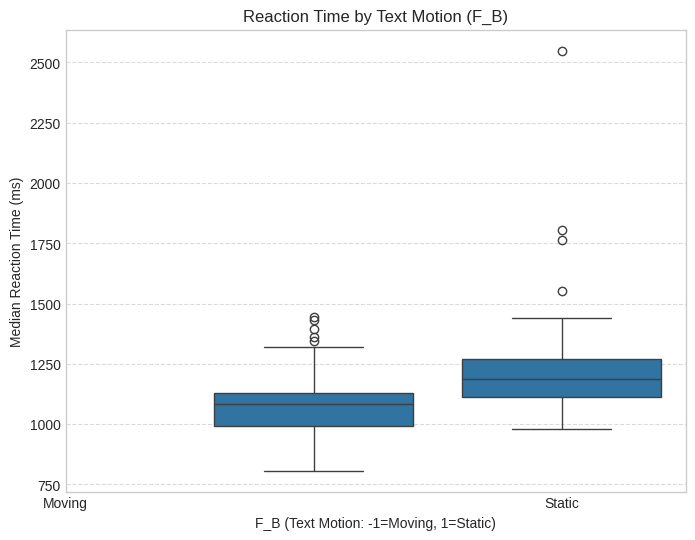

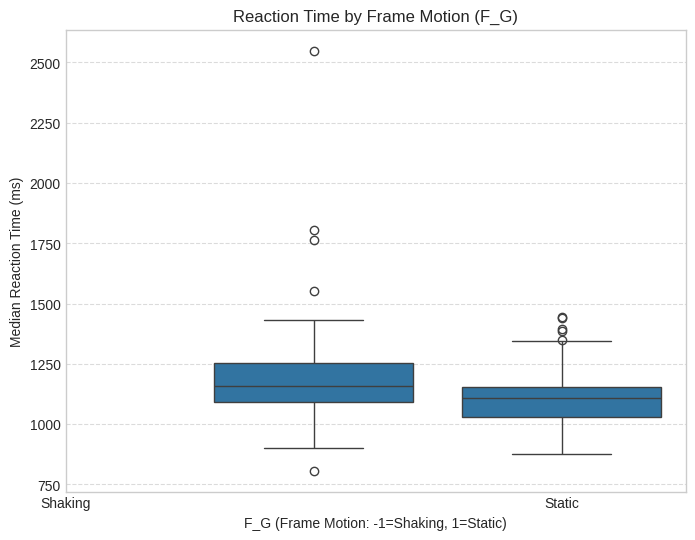

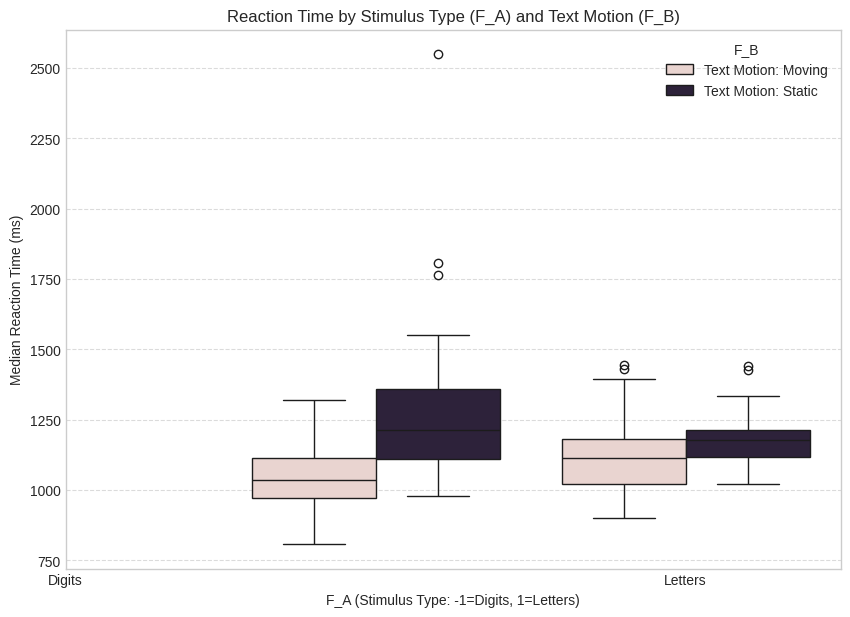

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Box plot for F_A (Stimulus Type)
plt.figure(figsize=(8, 6))
sns.boxplot(x='F_A', y='reaction_time_ms', data=summary)
plt.title('Reaction Time by Stimulus Type (F_A)')
plt.xlabel('F_A (Stimulus Type: -1=Digits, 1=Letters)')
plt.ylabel('Median Reaction Time (ms)')
plt.xticks(ticks=[-1, 1], labels=['Digits', 'Letters'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Box plot for F_B (Text Motion)
plt.figure(figsize=(8, 6))
sns.boxplot(x='F_B', y='reaction_time_ms', data=summary)
plt.title('Reaction Time by Text Motion (F_B)')
plt.xlabel('F_B (Text Motion: -1=Moving, 1=Static)')
plt.ylabel('Median Reaction Time (ms)')
plt.xticks(ticks=[-1, 1], labels=['Moving', 'Static'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Box plot for F_G (Frame Motion)
plt.figure(figsize=(8, 6))
sns.boxplot(x='F_G', y='reaction_time_ms', data=summary)
plt.title('Reaction Time by Frame Motion (F_G)')
plt.xlabel('F_G (Frame Motion: -1=Shaking, 1=Static)')
plt.ylabel('Median Reaction Time (ms)')
plt.xticks(ticks=[-1, 1], labels=['Shaking', 'Static'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Box plot for F_A:F_B Interaction
plt.figure(figsize=(10, 7))
sns.boxplot(x='F_A', y='reaction_time_ms', hue='F_B', data=summary)
plt.title('Reaction Time by Stimulus Type (F_A) and Text Motion (F_B)')
plt.xlabel('F_A (Stimulus Type: -1=Digits, 1=Letters)')
plt.ylabel('Median Reaction Time (ms)')
plt.xticks(ticks=[-1, 1], labels=['Digits', 'Letters'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Text Motion: Moving', 'Text Motion: Static'], title='F_B')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

These plots show an interesting dynamic. It is highly possible that the text motion increased our awareness and therefore decreased our reaction time, while the frame motion was too distracting.

In [ ]:
# Global Optimization
# We predict reaction time for ALL 128 combinations to find the absolute minimum.
grid_all = pd.DataFrame(
    np.array(np.meshgrid(*[[-1, 1]] * 7)).T.reshape(-1, 7),
    columns=factor_cols,
)
grid_all["student"] = model_df["student"].cat.categories[0]
grid_all["Predicted_RT"] = reduced_model.predict(grid_all)

opt_row = grid_all.loc[grid_all["Predicted_RT"].idxmin()]

print("--- OPTIMAL CONFIGURATION FOR MINIMUM REACTION TIME ---")
print(opt_row.drop("student"))

--- OPTIMAL CONFIGURATION FOR MINIMUM REACTION TIME ---
F_A                    -1
F_B                    -1
F_C                    -1
F_D                    -1
F_E                    -1
F_F                    -1
F_G                     1
Predicted_RT    785.09855
Name: 64, dtype: object


## 7. Final Conclusions

## 7. Final Conclusions

We analyzed a \(2^7\) factorial experiment on keyboard reaction times with four students as blocks and seven visual factors. After removing the first trial of each run and using median reaction time per treatment, we fitted a blocked linear model and used ANOVA and a Daniel plot to screen for important effects.

The block factor **student** is highly significant, so individual baseline speed must be accounted for. Among the experimental factors, only **text motion (F_B)**, **stimulus type (F_A)**, **frame motion (F_G)** and the interaction **F_A:F_B** show clear effects. This leads to the reduced model
$$
\text{RT} \sim \text{student} + (F_A + F_B + F_G + F_A:F_B).
$$

The model shows that **static text and a static frame** give the fastest reactions, while any motion slows people down. Digits are only clearly better than letters when the text is static.

Across all design points, the best setup is **digits, static text, and a static frame**; the other factors (background color, text color, font size, cue delay within the tested range) have no clear impact.

